In [1]:
from google.colab import files
uploaded = files.upload()

Saving liver_patient.csv to liver_patient.csv


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import numpy as np


Dataset Shape: (583, 11)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         583 non-null    int64  
 1   Gender                      583 non-null    object 
 2   Total_Bilirubin             583 non-null    float64
 3   Direct_Bilirubin            583 non-null    float64
 4   Alkaline_Phosphotase        583 non-null    int64  
 5   Alamine_Aminotransferase    583 non-null    int64  
 6   Aspartate_Aminotransferase  583 non-null    int64  
 7   Total_Protiens              583 non-null    float64
 8   Albumin                     583 non-null    float64
 9   Albumin_and_Globulin_Ratio  579 non-null    float64
 10  liver_disease               583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB

Missing Values:
 Age                           0
G

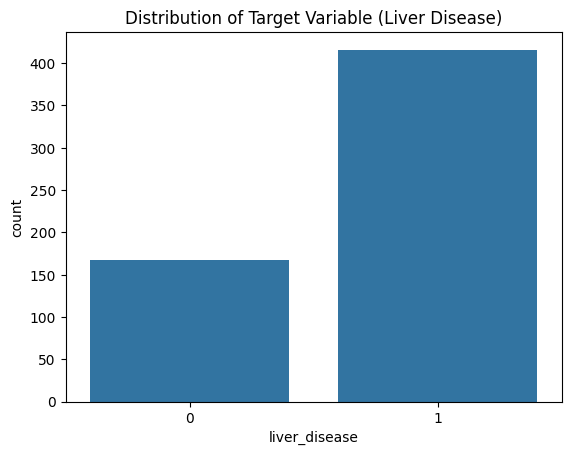

In [3]:
# Load the dataset
data = pd.read_csv('liver_patient.csv')

# Basic dataset overview
print("Dataset Shape:", data.shape)
print("\nDataset Info:")
data.info()
print("\nMissing Values:\n", data.isnull().sum())
print("\nSummary Statistics:\n", data.describe())

# Categorical variable analysis
print("\nUnique Values in Categorical Columns:")
for col in data.select_dtypes(include=['object']).columns:
    print(f"{col}: {data[col].unique()}")

# Distribution of the target variable
sns.countplot(x='liver_disease', data=data)
plt.title("Distribution of Target Variable (Liver Disease)")
plt.show()

# Numerical feature distributions with threshold explanations
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
thresholds = {
    "Age": 60,  # Threshold to distinguish older individuals likely at risk for liver issues
    "Total_Bilirubin": 1.2,  # Normal range upper limit for bilirubin
    "Direct_Bilirubin": 0.3,  # Normal range upper limit for direct bilirubin
    "Alkaline_Phosphotase": 120,  # Normal upper limit for alkaline phosphatase
    "Alamine_Aminotransferase": 40,  # Normal upper limit for ALT
    "Aspartate_Aminotransferase": 40,  # Normal upper limit for AST
    "Total_Protiens": 6.5,  # Normal lower limit for total proteins
    "Albumin": 3.5,  # Normal lower limit for albumin
    "Albumin_and_Globulin_Ratio": 1.0  # Balanced ratio as a healthy reference
}




Categorization of Age based on threshold 60:
Age_Category
Below Threshold    484
Above Threshold     99
Name: count, dtype: int64

Categorization of Total_Bilirubin based on threshold 1.2:
Total_Bilirubin_Category
Below Threshold    332
Above Threshold    251
Name: count, dtype: int64

Categorization of Direct_Bilirubin based on threshold 0.3:
Direct_Bilirubin_Category
Below Threshold    308
Above Threshold    275
Name: count, dtype: int64

Categorization of Alkaline_Phosphotase based on threshold 120:
Alkaline_Phosphotase_Category
Above Threshold    563
Below Threshold     20
Name: count, dtype: int64

Categorization of Alamine_Aminotransferase based on threshold 40:
Alamine_Aminotransferase_Category
Below Threshold    336
Above Threshold    247
Name: count, dtype: int64

Categorization of Aspartate_Aminotransferase based on threshold 40:
Aspartate_Aminotransferase_Category
Above Threshold    300
Below Threshold    283
Name: count, dtype: int64

Categorization of Total_Protiens based

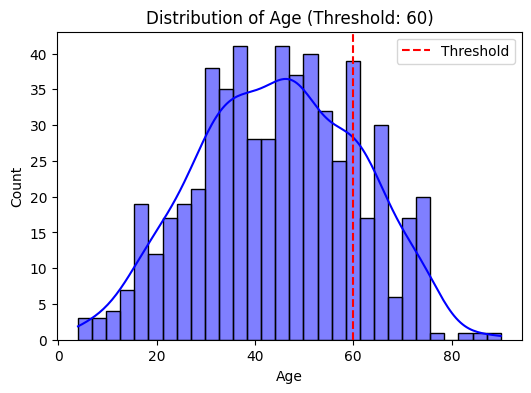

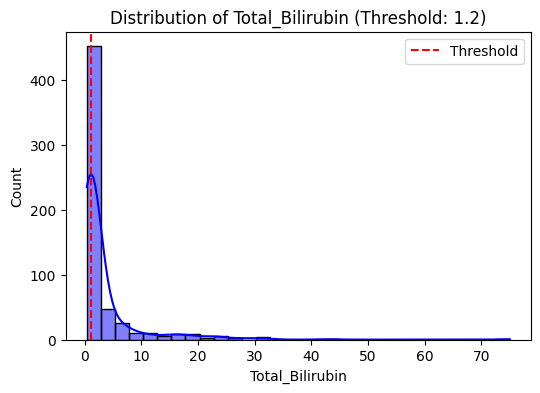

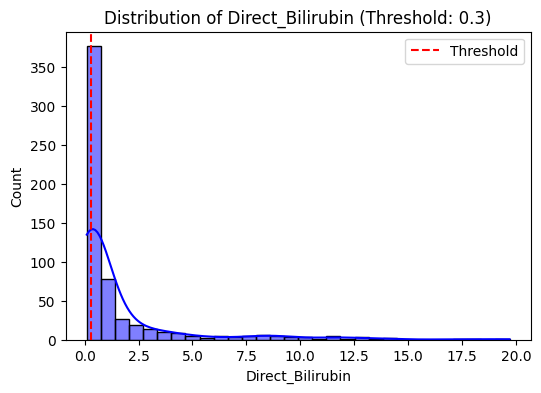

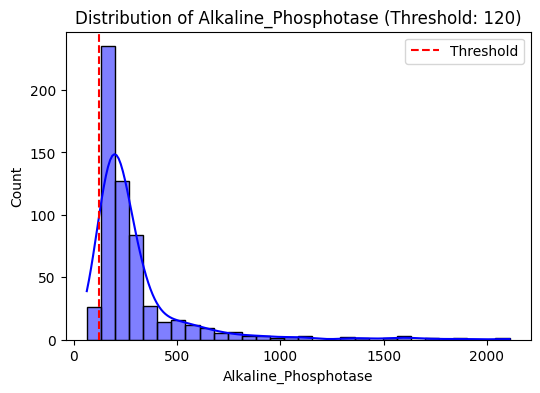

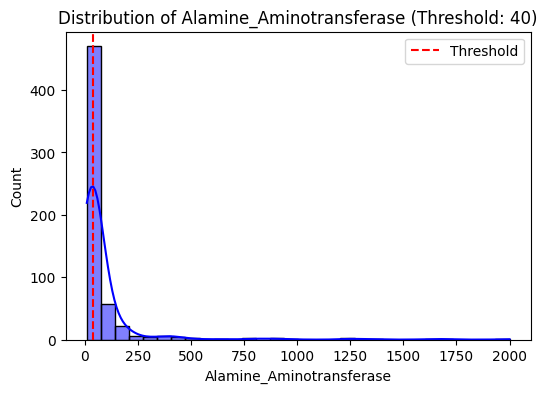

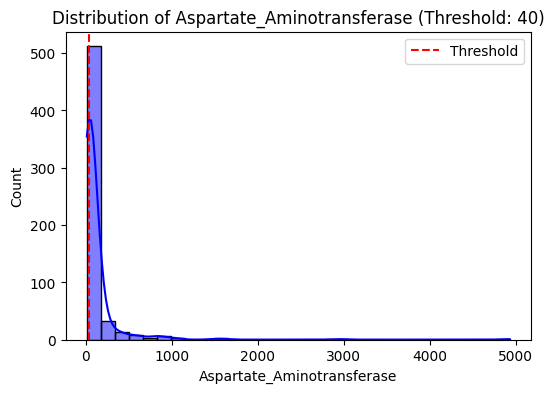

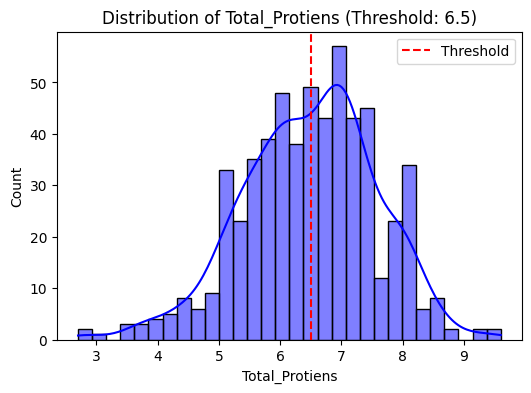

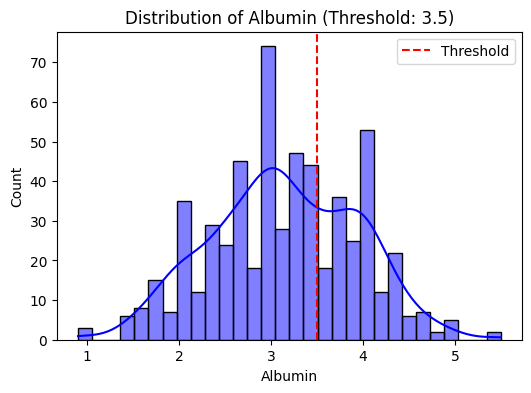

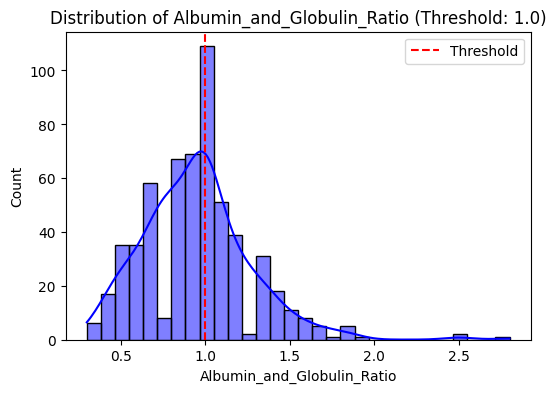

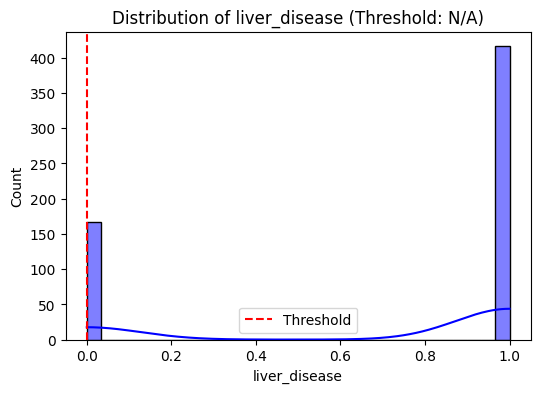

In [4]:
# Categorizing numerical columns based on thresholds
def categorize_column(value, threshold, higher_category="Above Threshold", lower_category="Below Threshold"):
    return higher_category if value > threshold else lower_category

for col, threshold in thresholds.items():
    category_col = f"{col}_Category"
    data[category_col] = data[col].apply(categorize_column, threshold=threshold)
    print(f"\nCategorization of {col} based on threshold {threshold}:")
    print(data[category_col].value_counts())

for col in numerical_columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(data[col], kde=True, bins=30, color='blue')
    plt.axvline(thresholds.get(col, 0), color='red', linestyle='--', label='Threshold')
    plt.title(f"Distribution of {col} (Threshold: {thresholds.get(col, 'N/A')})")
    plt.legend()
    plt.show()

In [5]:
# Binarizing necessary columns
binary_columns = {}
for col, threshold in thresholds.items():
    binary_col = f"{col}_Binary"
    data[binary_col] = (data[col] > threshold).astype(int)
    binary_columns[col] = binary_col

print("\nBinarized Columns:")
print(data[[binary_columns[col] for col in binary_columns]].head())


Binarized Columns:
   Age_Binary  Total_Bilirubin_Binary  Direct_Bilirubin_Binary  \
0           1                       0                        0   
1           1                       1                        1   
2           1                       1                        1   
3           0                       0                        1   
4           1                       1                        1   

   Alkaline_Phosphotase_Binary  Alamine_Aminotransferase_Binary  \
0                            1                                0   
1                            1                                1   
2                            1                                1   
3                            1                                0   
4                            1                                0   

   Aspartate_Aminotransferase_Binary  Total_Protiens_Binary  Albumin_Binary  \
0                                  0                      1               0   
1                     

In [6]:
# Splitting the data into train and test sets
feature_columns = [binary_columns[col] for col in binary_columns]
X = data[feature_columns]
y = data['liver_disease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
# Lazy FCA Model
class LazyFCA:
    def __init__(self):
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        predictions = []
        for _, test_instance in X_test.iterrows():
            distances = np.sum((self.X_train - test_instance) ** 2, axis=1)
            nearest_index = np.argmin(distances)
            predictions.append(self.y_train.iloc[nearest_index])
        return predictions


# Instantiate and evaluate the Lazy FCA model
lazy_fca = LazyFCA()
lazy_fca.fit(X_train, y_train)

# Predict on test set
y_pred_lazy_fca = lazy_fca.predict(X_test)

# Evaluate the Lazy FCA model
lazy_fca_accuracy = accuracy_score(y_test, y_pred_lazy_fca)
print("\nLazy FCA Model:")
print("Accuracy:", lazy_fca_accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred_lazy_fca))


Lazy FCA Model:
Accuracy: 0.7085714285714285

Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.45      0.45        47
           1       0.80      0.80      0.80       128

    accuracy                           0.71       175
   macro avg       0.63      0.63      0.63       175
weighted avg       0.71      0.71      0.71       175



In [8]:
# Logistic Regression
def logistic_regression_classifier(X_train, y_train, X_test):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

y_pred_lr = logistic_regression_classifier(X_train, y_train, X_test)
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print("\nLogistic Regression Classifier:")
print("Accuracy:", lr_accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))


Logistic Regression Classifier:
Accuracy: 0.7257142857142858

Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.17      0.25        47
           1       0.75      0.93      0.83       128

    accuracy                           0.73       175
   macro avg       0.61      0.55      0.54       175
weighted avg       0.68      0.73      0.68       175



In [9]:
# Decision Tree Classifier
def decision_tree_classifier(X_train, y_train, X_test):
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

y_pred_dt = decision_tree_classifier(X_train, y_train, X_test)
dt_accuracy = accuracy_score(y_test, y_pred_dt)
print("\nDecision Tree Classifier:")
print("Accuracy:", dt_accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))


Decision Tree Classifier:
Accuracy: 0.6857142857142857

Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.30      0.34        47
           1       0.76      0.83      0.79       128

    accuracy                           0.69       175
   macro avg       0.58      0.56      0.57       175
weighted avg       0.66      0.69      0.67       175



In [10]:
# Random Forest Classifier
def random_forest_classifier(X_train, y_train, X_test):
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

y_pred_rf = random_forest_classifier(X_train, y_train, X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print("\nRandom Forest Classifier:")
print("Accuracy:", rf_accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Classifier:
Accuracy: 0.68

Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.28      0.32        47
           1       0.76      0.83      0.79       128

    accuracy                           0.68       175
   macro avg       0.56      0.55      0.55       175
weighted avg       0.65      0.68      0.66       175



In [11]:
# Support Vector Classifier (SVC)
def support_vector_classifier(X_train, y_train, X_test):
    model = SVC()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

y_pred_svc = support_vector_classifier(X_train, y_train, X_test)
svc_accuracy = accuracy_score(y_test, y_pred_svc)
print("\nSupport Vector Classifier:")
print("Accuracy:", svc_accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred_svc))


Support Vector Classifier:
Accuracy: 0.6971428571428572

Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.15      0.21        47
           1       0.74      0.90      0.81       128

    accuracy                           0.70       175
   macro avg       0.55      0.52      0.51       175
weighted avg       0.64      0.70      0.65       175



In [12]:
# K-Nearest Neighbors Classifier
def knn_classifier(X_train, y_train, X_test):
    model = KNeighborsClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

y_pred_knn = knn_classifier(X_train, y_train, X_test)
knn_accuracy = accuracy_score(y_test, y_pred_knn)
print("\nK-Nearest Neighbors Classifier:")
print("Accuracy:", knn_accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))


K-Nearest Neighbors Classifier:
Accuracy: 0.7142857142857143

Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.38      0.42        47
           1       0.79      0.84      0.81       128

    accuracy                           0.71       175
   macro avg       0.62      0.61      0.61       175
weighted avg       0.70      0.71      0.71       175



In [13]:
# Naive Bayes Classifier
def naive_bayes_classifier(X_train, y_train, X_test):
    model = GaussianNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

y_pred_nb = naive_bayes_classifier(X_train, y_train, X_test)
nb_accuracy = accuracy_score(y_test, y_pred_nb)
print("\nNaive Bayes Classifier:")
print("Accuracy:", nb_accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))


Naive Bayes Classifier:
Accuracy: 0.6742857142857143

Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.70      0.54        47
           1       0.86      0.66      0.75       128

    accuracy                           0.67       175
   macro avg       0.65      0.68      0.64       175
weighted avg       0.74      0.67      0.69       175



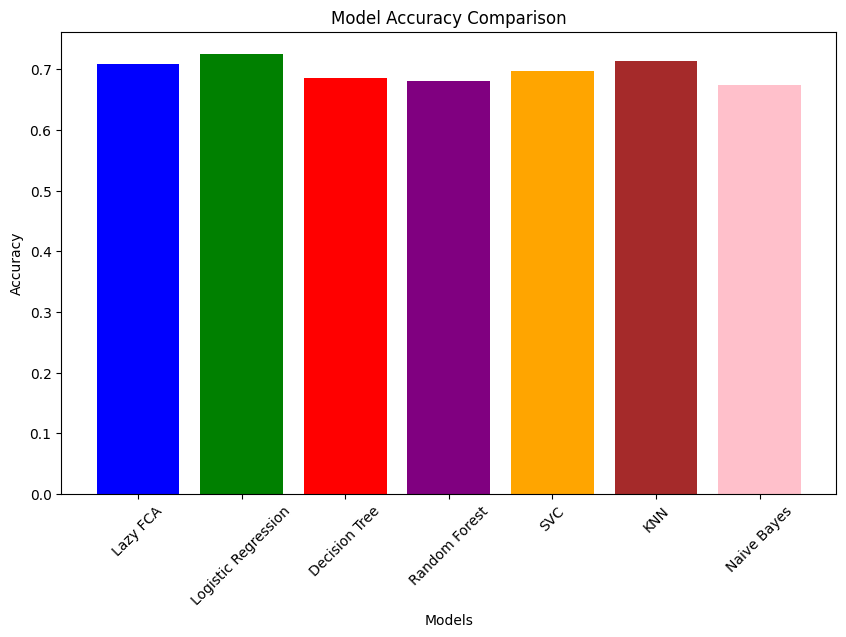

In [14]:
# Accuracy comparison
models = ["Lazy FCA", "Logistic Regression", "Decision Tree", "Random Forest", "SVC", "KNN", "Naive Bayes"]
accuracies = [lazy_fca_accuracy, lr_accuracy, dt_accuracy, rf_accuracy, svc_accuracy, knn_accuracy, nb_accuracy]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink'])
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=45)
plt.show()

Lazy FCA accuracy on the raw dataset

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import KBinsDiscretizer
from itertools import combinations
from sklearn.impute import SimpleImputer # Importing SimpleImputer for handling NaNs

# Load dataset and prepare binary context
dataset = pd.read_csv('liver_patient.csv')  # Replace with your dataset path
target_column = 'liver_disease'

# Discretize numerical features
numerical_features = dataset.select_dtypes(include=['float64', 'int64']).columns[:-1]  # Exclude target

# Impute missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean') # Replace 'mean' with desired strategy if needed
dataset[numerical_features] = imputer.fit_transform(dataset[numerical_features])

discretizer = KBinsDiscretizer(n_bins=3, encode='onehot-dense', strategy='uniform')
binarized_numerical = discretizer.fit_transform(dataset[numerical_features])
binary_numerical = pd.DataFrame(
    binarized_numerical,
    columns=[f"{col}_bin_{i}" for col in numerical_features for i in range(1, 4)]
)
binary_categorical = pd.get_dummies(dataset['Gender'], prefix='Gender')
binary_context = pd.concat([binary_numerical, binary_categorical], axis=1)
binary_context[target_column] = dataset[target_column]

# Lazy FCA Implementation
class LazyFCA:
    def __init__(self, context):
        self.context = context

    def extent(self, attributes):
        """Find objects sharing all given attributes."""
        mask = self.context[attributes].all(axis=1)
        return set(self.context[mask].index)

    def intent(self, objects):
        """Find attributes shared by all given objects."""
        # Convert the set of objects to a list for indexing
        objects_list = list(objects)
        return set(self.context.loc[objects_list].all(axis=0)[lambda x: x].index)

    def classify(self, test_row, target_attribute):
        """Classify based on attributes in the binary context."""
        attributes = test_row.index[test_row == 1].tolist()
        objects, _ = self.generate_concept(None, attributes)
        # Convert the set of objects to a list for indexing
        objects_list = list(objects)
        target_values = self.context.loc[objects_list, target_attribute].value_counts()
        return target_values.idxmax() if not target_values.empty else 0

    def generate_concept(self, objects, attributes):
        """Generate a concept from a set of objects or attributes."""
        new_objects = self.extent(attributes)
        new_attributes = self.intent(new_objects)
        return new_objects, new_attributes

# Split data into training and test sets
X = binary_context.drop(columns=[target_column])
y = binary_context[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Lazy FCA model
train_context = pd.concat([X_train, y_train], axis=1)
fca = LazyFCA(train_context)

# Predict on the test set
predictions = []
for _, test_row in X_test.iterrows():
    predictions.append(fca.classify(test_row, target_column))

# Compute accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy of Lazy FCA: {accuracy:.2f}")

Accuracy of Lazy FCA: 0.65
